# Between model
This model takes as input any variable that is static, that is the OSM variables, ESA Landcover variables and the WSF variables. Moreover, it takes the mean over all dynamic variables. The dynamic variables include Nightlights, NDVI, and NDWI_Gao as well as NDWI_McF. 

The idea is that the between model captures variation between clusters and thus the target variable for the between model is $\bar{w}_c = \frac{1}{T_c}\sum_t^{T_c} w_{c,t}$ 

# Within model
This goal of this model is to predict the deviations from the cluster mean for each year. I.e. the model should capture variation within each cluster. To do so, the target variable is $\tilde{w}_{ct} = w_{ct} - \bar{w}_{c}$. 

For cluster $c$ in time period $t$, the feature vector is defined as $\tilde{\boldsymbol{x}}_{ct} = \boldsymbol{x}_{ct} - \bar{\boldsymbol{x}}_{c}, where~\bar{\boldsymbol{x}}_{c} \in \mathbb{R}^{k\times1}$. 

To predict $\tilde{w}_{ct}$, I rely on $\tilde{\boldsymbol{x}}_{ct}$. This allows me to interpret the performance metric as the within R2, i.e. the share of the variance the model captures within clusters. 


(this does not help at all, thus disregard)...
To augment the number of training observations, I train the model on deltas, rather than on the demeaned variables. This substantially increases the number of training observations and covers a wider range of differences, making the training dataset more versatile and robust. Ideally, this helps to learn from a wider range of differences and thus increases the out-of-sample when predicting $\tilde{\boldsymbol{w}}_{ct}$.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pickle
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
# set the font size for matplotlib and the font family.
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
# load the necessary functions from the analysis package

# load the variable names, this allows to access the variables in the feature data in a compact way
from analysis_utils.variable_names import *

# load flagged ids 
from analysis_utils.flagged_uids import *

# load the functions to do spatial k-fold CV
from analysis_utils.spatial_CV import *

# load the helper functions
from analysis_utils.analysis_helpers import *

# load the random forest trainer and cross_validator
import analysis_utils.RandomForest as rf

# load the combien model
from analysis_utils.CombinedModel import CombinedModel

In [4]:
# set the global file paths
root_data_dir = "../../Data"

# the lsms data
lsms_pth = f"{root_data_dir}/lsms/processed/labels_cluster_v1.csv"

# the feature data
feat_data_pth = f"{root_data_dir}/feature_data/tabular_data.csv"

# set the random seed
random_seed = 423
spatial_cv_random_seed = 348

# set the number of folds for k-fold CV
n_folds = 5

In [5]:
# load the feature and the label data
lsms_df = pd.read_csv(lsms_pth)
# remove flagged ids form dataset
lsms_df = lsms_df[~lsms_df.unique_id.isin(flagged_uids)].reset_index()
lsms_df['avg_log_mean_pc_cons_usd_2017'] = lsms_df.groupby('cluster_id')['log_mean_pc_cons_usd_2017'].transform('mean')
lsms_df['avg_mean_asset_index_yeh'] = lsms_df.groupby('cluster_id')['mean_asset_index_yeh'].transform('mean')
feat_df = pd.read_csv(feat_data_pth)

# describe the training data broadly
print(f"Number of observations {len(lsms_df)}")
print(f"Number of clusters {len(np.unique(lsms_df.cluster_id))}")
print(f"Number of x vars {len(feat_df.columns)-2}")

Number of observations 6401
Number of clusters 2128
Number of x vars 113


In [6]:
# merge the label and the feature data to one dataset
lsms_vars = ['unique_id', 'n_households',           
             'log_mean_pc_cons_usd_2017', 'avg_log_mean_pc_cons_usd_2017',
             'mean_asset_index_yeh', 'avg_mean_asset_index_yeh']
df = pd.merge(lsms_df[lsms_vars], feat_df, on = 'unique_id', how = 'left')

# Run Training

In [7]:
# define the within and between x variables
avg_rs_vars = avg_ndvi_vars + avg_ndwi_gao_vars + avg_nl_vars
osm_vars = osm_dist_vars + osm_count_vars + osm_road_vars

between_x_vars = osm_vars + esa_lc_vars + wsf_vars + avg_rs_vars + avg_preciptiation + median_rgb_vars

dyn_rs_vars = dyn_ndvi_vars + dyn_ndwi_gao_vars + dyn_nl_vars
within_x_vars = dyn_rs_vars + precipitation + dyn_rgb_vars

### Target: Log per capita consumption

In [8]:
between_target_var = 'avg_log_mean_pc_cons_usd_2017'
cl_df = df[['cluster_id', between_target_var] + between_x_vars].drop_duplicates().reset_index(drop = True)

# normalise the feature data
cl_df_norm = standardise_df(cl_df, exclude_cols = [between_target_var])

In [9]:
# get the within dataframe
# define the within variables
within_target_var = 'log_mean_pc_cons_usd_2017'
within_df = df[['cluster_id','unique_id', within_target_var] + within_x_vars]

# demean the data and standardise the variables
demeaned_df = demean_df(within_df)
demeaned_df_norm = standardise_df(demeaned_df, exclude_cols = [within_target_var])

In [10]:
# run repeated cross validation
rep_cv_res_cons = {
    'between_r2': [],
    'within_r2': [],
    'overall_r2': []
}

for j in range(10):
    print("="*100)
    print(f"Iteration {j}")
    print("="*100)
    rep_seed = random_seed + j
    
    # divide the data into k different folds
    fold_ids = split_lsms_spatial(lsms_df, n_folds = n_folds, random_seed = spatial_cv_random_seed + j)
    
    # run the bewtween training
    print('Between training')
    between_cv_trainer_cons = rf.CrossValidator(cl_df_norm, 
                                                fold_ids, 
                                                between_target_var, 
                                                between_x_vars, 
                                                id_var = 'cluster_id', 
                                                random_seed = rep_seed)
    between_cv_trainer_cons.run_cv_training(min_samples_leaf = 1)
    
    # run the within training
    print("\nWithin training")
    within_cv_trainer_cons = rf.CrossValidator(demeaned_df_norm, 
                                               fold_ids, 
                                               within_target_var, 
                                               within_x_vars, 
                                               id_var = 'unique_id', 
                                               random_seed = rep_seed)
    within_cv_trainer_cons.run_cv_training(min_samples_leaf = 1)
    
    # combine both models
    combined_model_cons = CombinedModel(lsms_df, between_cv_trainer_cons, within_cv_trainer_cons)
    combined_model_cons.evaluate()
    combined_results = combined_model_cons.compute_overall_performance(use_fold_weights = True)
    
    # store the results 
    rep_cv_res_cons['between_r2'].append(combined_results['r2']['between'])
    rep_cv_res_cons['within_r2'].append(combined_results['r2']['within'])
    rep_cv_res_cons['overall_r2'].append(combined_results['r2']['overall'])
    
    # print the results
    print("."*100)
    print(combined_results)
    print("."*100)

Iteration 0
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 225 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 635 seconds
....................................................................................................
{'r2': {'overall': 0.39155521378372043, 'between': 0.4680397028161642, 'within': 0.003705636198842055}, 'mse': {'overall': 0.21292499678356339, 'between': 0.15544672368474663, 'within': 0.055883566073491764}}
....................................................................................................
Iteration 1
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 207 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 618 seconds
....................................................................................................
{'r2': {'overall': 0.3632369829994231, 'between': 0.4373700346429812, 'within': 0.0018537607486119212}, 'mse': {'overall': 0.21381906535755235, 'between': 0.1563233863099223, 'within': 0.0560120688234916}}
....................................................................................................
Iteration 2
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 215 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 612 seconds
....................................................................................................
{'r2': {'overall': 0.38917189553959275, 'between': 0.4703481901733915, 'within': 0.00237859081132914}, 'mse': {'overall': 0.21082247476267438, 'between': 0.15275229044326138, 'within': 0.05581419176714793}}
....................................................................................................
Iteration 3
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 203 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 597 seconds
....................................................................................................
{'r2': {'overall': 0.3664360324487099, 'between': 0.44387537729956195, 'within': 0.008591513752220493}, 'mse': {'overall': 0.21271344532624759, 'between': 0.15538676518979067, 'within': 0.055612671045043895}}
....................................................................................................
Iteration 4
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 204 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 599 seconds
....................................................................................................
{'r2': {'overall': 0.3723362651615978, 'between': 0.44668153536773103, 'within': -0.0015186259292346849}, 'mse': {'overall': 0.21502889952020454, 'between': 0.1568348807528071, 'within': 0.05634750434870563}}
....................................................................................................
Iteration 5
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 196 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 606 seconds
....................................................................................................
{'r2': {'overall': 0.38435210321311375, 'between': 0.4603291929287872, 'within': 0.00557204768222479}, 'mse': {'overall': 0.21001375106732884, 'between': 0.15233050590403518, 'within': 0.056548653399934715}}
....................................................................................................
Iteration 6
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 202 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 609 seconds
....................................................................................................
{'r2': {'overall': 0.38722803466250666, 'between': 0.4653559140463946, 'within': 0.007717241156519816}, 'mse': {'overall': 0.21165597495621868, 'between': 0.1537418243454254, 'within': 0.05554887488447757}}
....................................................................................................
Iteration 7
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 205 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 603 seconds
....................................................................................................
{'r2': {'overall': 0.37614271414402994, 'between': 0.45284080864933723, 'within': 0.005552845649828742}, 'mse': {'overall': 0.21066042633531942, 'between': 0.15363118655566205, 'within': 0.05632444158107837}}
....................................................................................................
Iteration 8
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 200 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 605 seconds
....................................................................................................
{'r2': {'overall': 0.3738208145856476, 'between': 0.4575603867917326, 'within': 0.005820838823327401}, 'mse': {'overall': 0.21283779099020836, 'between': 0.15413245592899416, 'within': 0.05555108438759515}}
....................................................................................................
Iteration 9
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 193 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 608 seconds
....................................................................................................
{'r2': {'overall': 0.38018968916801243, 'between': 0.4588353562899485, 'within': 0.007362914972187018}, 'mse': {'overall': 0.21224794884267079, 'between': 0.15447896843223147, 'within': 0.05567021959741114}}
....................................................................................................


In [11]:
pth = 'results/baseline_ls/rep_cv_res_cons.pkl'
with open(pth, 'wb') as f:
    pickle.dump(rep_cv_res_cons, f)

In [12]:
mean_r2_cons = {k: np.mean(v) for k,v in rep_cv_res_cons.items()}
se_r2_cons = {k: np.std(v)/np.sqrt(10) for k,v in rep_cv_res_cons.items()}

# print as tex
print(f"& {mean_r2_cons['between_r2']:.4f} & {mean_r2_cons['within_r2']:.4f} & {mean_r2_cons['overall_r2']:.4f} \\\\")
print(f"& \\footnotesize({se_r2_cons['between_r2']:.4f}) & \\footnotesize({se_r2_cons['within_r2']:.4f}) & \\footnotesize({se_r2_cons['overall_r2']:.4f})\\\\")

& 0.4561 & 0.0047 & 0.3784 \\
& \footnotesize(0.0033) & \footnotesize(0.0009) & \footnotesize(0.0029)\\


In [13]:
print(mean_r2_cons)

{'between_r2': 0.45612364990060306, 'within_r2': 0.004703676386585669, 'overall_r2': 0.3784469745706355}


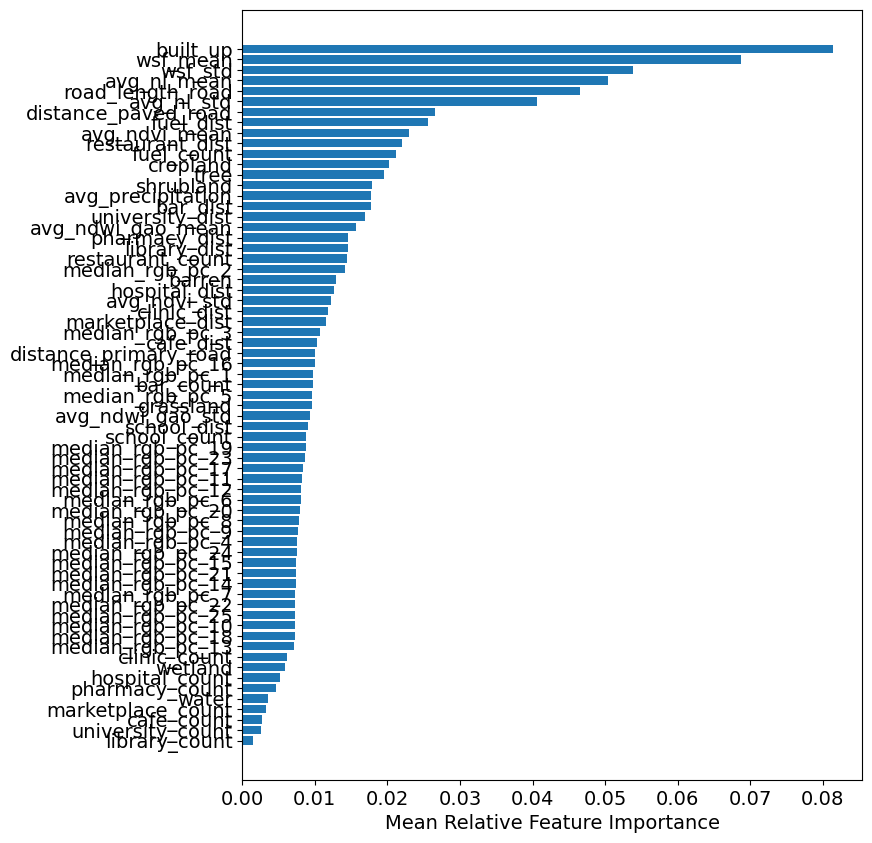

In [14]:
between_cv_trainer_cons.plot_feature_importance(fname = None)

### Target: Asset index

In [15]:
# get a dataset that only varies at the cluster level
between_target_var = 'avg_mean_asset_index_yeh'
cl_df = df[['cluster_id', between_target_var] + between_x_vars].drop_duplicates().reset_index(drop = True)

# normalise the feature data
cl_df_norm = standardise_df(cl_df, exclude_cols = [between_target_var])

In [16]:
# define the within variables
within_target_var = 'mean_asset_index_yeh'
within_df = df[['cluster_id','unique_id', within_target_var] + within_x_vars]

# demean the data and standardise the variables
demeaned_df = demean_df(within_df)
demeaned_df_norm = standardise_df(demeaned_df, exclude_cols = [within_target_var])

In [17]:
# run repeated cross validation
rep_cv_res_asset = {
    'between_r2': [],
    'within_r2': [],
    'overall_r2': []
}

for j in range(10):
    print("="*100)
    print(f"Iteration {j}")
    print("="*100)
    rep_seed = random_seed + j
    
    # divide the data into k different folds
    fold_ids = split_lsms_spatial(lsms_df, n_folds = n_folds, random_seed = spatial_cv_random_seed + j)
    
    # run the bewtween training
    print('Between training')
    between_cv_trainer_asset = rf.CrossValidator(cl_df_norm, 
                                                fold_ids, 
                                                between_target_var, 
                                                between_x_vars, 
                                                id_var = 'cluster_id', 
                                                random_seed = rep_seed)
    between_cv_trainer_asset.run_cv_training(min_samples_leaf = 1)
    
    # run the within training
    print("\nWithin training")
    within_cv_trainer_asset = rf.CrossValidator(demeaned_df_norm, 
                                               fold_ids, 
                                               within_target_var, 
                                               within_x_vars, 
                                               id_var = 'unique_id', 
                                               random_seed = rep_seed)
    within_cv_trainer_asset.run_cv_training(min_samples_leaf = 1)
    
    # combine both models
    combined_model_asset = CombinedModel(lsms_df, between_cv_trainer_asset, within_cv_trainer_asset)
    combined_model_asset.evaluate()
    combined_results = combined_model_asset.compute_overall_performance(use_fold_weights = True)
    
    # store the results 
    rep_cv_res_asset['between_r2'].append(combined_results['r2']['between'])
    rep_cv_res_asset['within_r2'].append(combined_results['r2']['within'])
    rep_cv_res_asset['overall_r2'].append(combined_results['r2']['overall'])
    
    # print the results
    print("."*100)
    print(combined_results)
    print("."*100)

Iteration 0
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 197 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 642 seconds
....................................................................................................
{'r2': {'overall': 0.4974812136858438, 'between': 0.511914212918517, 'within': 0.03677228901274805}, 'mse': {'overall': 1.1188031263775051, 'between': 1.186998658499354, 'within': 0.0730281764905782}}
....................................................................................................
Iteration 1
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 191 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 644 seconds
....................................................................................................
{'r2': {'overall': 0.4792636867934513, 'between': 0.49889247755311256, 'within': 0.034934219695046065}, 'mse': {'overall': 1.1077049307450417, 'between': 1.168068975150059, 'within': 0.07322752772552979}}
....................................................................................................
Iteration 2
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 195 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 638 seconds
....................................................................................................
{'r2': {'overall': 0.49193002727884094, 'between': 0.5095096586567669, 'within': 0.041650681468429054}, 'mse': {'overall': 1.1092126543748655, 'between': 1.1727883654121796, 'within': 0.07282544697957753}}
....................................................................................................
Iteration 3
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.17
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 203 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 651 seconds
....................................................................................................
{'r2': {'overall': 0.4794398632144203, 'between': 0.49386352260951977, 'within': 0.03265507712253339}, 'mse': {'overall': 1.1195535351604335, 'between': 1.1852278707296993, 'within': 0.07232836076544688}}
....................................................................................................
Iteration 4
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 211 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 638 seconds
....................................................................................................
{'r2': {'overall': 0.4744537176020692, 'between': 0.4851591626062994, 'within': 0.03815951543170763}, 'mse': {'overall': 1.1133279401064229, 'between': 1.185947457502159, 'within': 0.0720485512907085}}
....................................................................................................
Iteration 5
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.26
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.13
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 210 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 645 seconds
....................................................................................................
{'r2': {'overall': 0.4629666087133664, 'between': 0.46913729535421445, 'within': 0.035469432143868794}, 'mse': {'overall': 1.1155303394027036, 'between': 1.1925117338690798, 'within': 0.07157280352445036}}
....................................................................................................
Iteration 6
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.18
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 207 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 655 seconds
....................................................................................................
{'r2': {'overall': 0.4910382229366641, 'between': 0.5074997725684639, 'within': 0.03745563494769917}, 'mse': {'overall': 1.1195826700899894, 'between': 1.1757306084233676, 'within': 0.07223725376905081}}
....................................................................................................
Iteration 7
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.25
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.14
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 210 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 649 seconds
....................................................................................................
{'r2': {'overall': 0.47217696864759795, 'between': 0.48317115568569446, 'within': 0.03650029749492849}, 'mse': {'overall': 1.1069601049453, 'between': 1.1840521054884658, 'within': 0.07171376981608563}}
....................................................................................................
Iteration 8
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.23
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.16
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 210 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 651 seconds
....................................................................................................
{'r2': {'overall': 0.47785576126761387, 'between': 0.487822956737478, 'within': 0.036033039565457024}, 'mse': {'overall': 1.1039645641277318, 'between': 1.1776162092659368, 'within': 0.07210935716889892}}
....................................................................................................
Iteration 9
Fold 0, specified test ratio: 0.2 - Actual test ratio 0.21
Fold 1, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 2, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 3, specified test ratio: 0.2 - Actual test ratio 0.20
Fold 4, specified test ratio: 0.2 - Actual test ratio 0.19
Between training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 192 seconds

Within training
Initialising training


  0%|          | 0/5 [00:00<?, ?it/s]

Finished training after 635 seconds
....................................................................................................
{'r2': {'overall': 0.48155910992923245, 'between': 0.5019702444655766, 'within': 0.03447802771751514}, 'mse': {'overall': 1.1071112427288183, 'between': 1.1641378535155429, 'within': 0.07304402600709223}}
....................................................................................................


In [18]:
pth = 'results/baseline_ls/rep_cv_res_asset.pkl'
with open(pth, 'wb') as f:
    pickle.dump(rep_cv_res_asset, f)

In [19]:
mean_r2_asset = {k: np.mean(v) for k,v in rep_cv_res_asset.items()}
se_r2_asset = {k: np.std(v)/np.sqrt(10) for k,v in rep_cv_res_asset.items()}

# print as tex
print(f"& {mean_r2_asset['between_r2']:.4f} & {mean_r2_asset['within_r2']:.4f} & {mean_r2_asset['overall_r2']:.4f} \\\\")
print(f"& \\footnotesize({se_r2_asset['between_r2']:.4f}) & \\footnotesize({se_r2_asset['within_r2']:.4f}) & \\footnotesize({se_r2_asset['overall_r2']:.4f})\\\\")

& 0.4949 & 0.0364 & 0.4808 \\
& \footnotesize(0.0041) & \footnotesize(0.0007) & \footnotesize(0.0031)\\


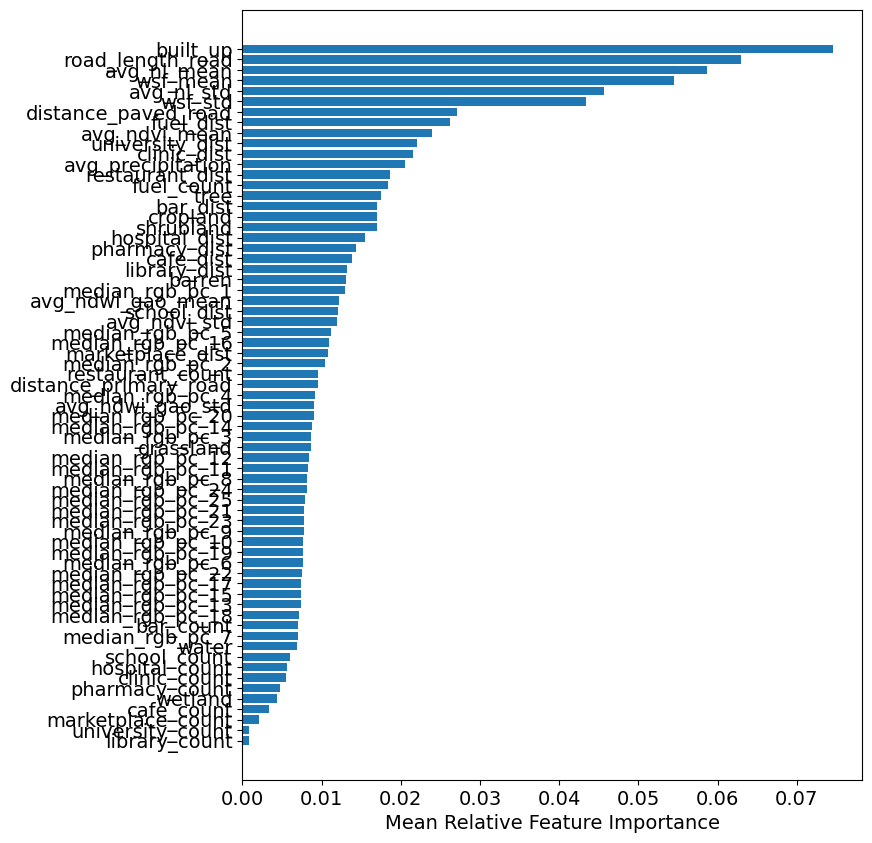

In [20]:
between_cv_trainer_asset.plot_feature_importance(fname = None)